# Data pre-processing for Climate Spirals Visualisation

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## CO<sub>2</sub> emissions from PRIMAP-hist


Historical CO<sub>2</sub> emissions are taken from the [PRIMAP-hist dataset](https://www.pik-potsdam.de/primap-live/primap-hist/) (Gütschow et al., 2016, in review).

- Earth System Science Data (ESSD) discussion paper:
[The PRIMAP-hist national historical emissions time series](http://www.earth-syst-sci-data-discuss.net/essd-2016-12/)
- Dataset: http://doi.org/10.5880/PIK.2016.003

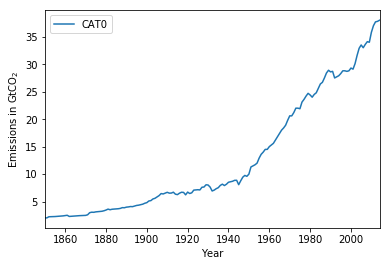

In [2]:
primaphist = pd.read_csv("PRIMAP-hist_v1.1_06-Mar-2017.csv")
primaphist = primaphist[(primaphist.country == "EARTH") & 
                        (primaphist.entity == "CO2") &
                        (primaphist.category == "CAT0")]
primaphist = primaphist.drop(['scenario', 'country', 'category', 'entity', 'unit'], axis=1).T
primaphist.index.name = "year"
primaphist.index = primaphist.index.astype(int)
primaphist.columns = ["CAT0"]
primaphist = primaphist / 1000000 # convert to Gt
primaphist.plot()
plt.xlabel("Year")
plt.ylabel(u"Emissions in GtCO$_2$")

As bunkers (international aviation and shipping) are not included in PRIMAP-hist they are taken from the [CDIAC](http://cdiac.ornl.gov/trends/emis/meth_reg.html) dataset which includes bunkers from 1950 onwards.

In [3]:
!head nation.1751_2013.csv

"Nation","Year","Total CO2 emissions from fossil-fuels and cement production (thousand metric tons of C)","Emissions from solid fuel consumption","Emissions from liquid fuel consumption","Emissions from gas fuel consumption","Emissions from cement production","Emissions from gas flaring","Per capita CO2 emissions (metric tons of carbon)","Emissions from bunker fuels (not included in the totals)"
(Note: missing values denoted by ".")
Source: Tom Boden and Bob Andres (Oak Ridge National Laboratory); Gregg Marland (Appalachian State University)
DOI: 10.3334/CDIAC/00001_V2016
"AFGHANISTAN",1949,4,4,0,0,0,.,.,0
"AFGHANISTAN",1950,23,6,18,0,0,0,0,0
"AFGHANISTAN",1951,25,7,18,0,0,0,0,0
"AFGHANISTAN",1952,25,9,17,0,0,0,0,0
"AFGHANISTAN",1953,29,10,18,0,0,0,0,0
"AFGHANISTAN",1954,29,12,18,0,0,0,0,0


In [4]:
cdiac = pd.read_csv("nation.1751_2013.csv", skiprows=[1, 2, 3], usecols=[0, 1, 9]) 

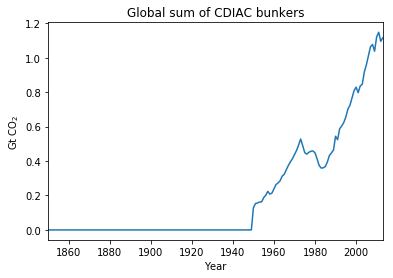

In [5]:
bunkers = cdiac.groupby("Year").sum().loc[1850:2013] * 3.667 / 1000000 # from kt C to Gt CO2
bunkers.columns = ["Bunkers"]
bunkers = bunkers.Bunkers
bunkers.plot()
plt.ylabel("Gt CO$_2$")
plt.title("Global sum of CDIAC bunkers")

### Extension of CDIAC bunkers
CDIAC bunkers are extended until 2014 the same way as missing data in the PRIMAP-hist paper (15 year trend).

/home/robert/dev/openclimatedata/climate-spirals/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


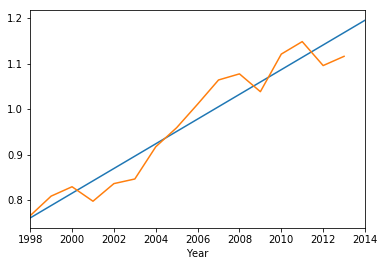

In [6]:
start = bunkers.index[-1] - 15
sel = bunkers.loc[start:]
slope, intercept, r_value, p_value, std_err = stats.linregress(sel.index, sel)
new_index = pd.Index(range(start, 2015))
extrapolation = pd.Series(new_index * slope + intercept, index=new_index)
ax = extrapolation.plot()
sel.plot(ax=ax)
bunkers.set_value(2014, extrapolation.loc[2014])
bunkers = bunkers.round(2)

Total emissions are PRIMAP-hist plus CDIAC bunkers (assuming pre-1950 bunkers being negligible).

In [7]:
total = primaphist.join(bunkers).sum(axis=1)

[BP](http://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/co2-emissions.html) estimates the energy related CO<sub>2</sub> emissions to be increased by 0.1% in 2015. Applying this to non-energy sectors as well we can get a rough estimate for 2015 emissions by simply re-using the 2014 value.

In [8]:
total = total.set_value(2015, total.loc[2014])

/home/robert/dev/openclimatedata/climate-spirals/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


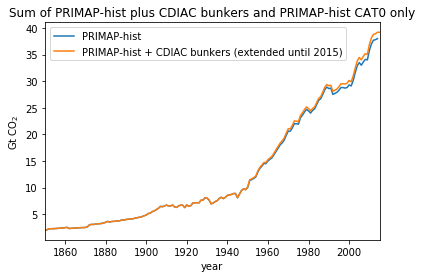

In [9]:
ax = primaphist.plot()
total.plot(ax=ax)
plt.title("Sum of PRIMAP-hist plus CDIAC bunkers and PRIMAP-hist CAT0 only")
plt.legend(["PRIMAP-hist", "PRIMAP-hist + CDIAC bunkers (extended until 2015)"], loc="best")
plt.ylabel("Gt CO$_2$")

Export for visualisation

In [10]:
export = pd.DataFrame({"value": total})

In [11]:
export.reset_index().to_csv("../public/emissions.csv", index=False)
export.tail()

,value
year,
2011,38.15
2012,38.80
2013,38.92
2014,39.20
2015,39.20


### Comparison with IPCC AR5 Synthesis Report budgets

Table 2.2 in the IPCC AR5 Synthesis Report:
http://www.ipcc.ch/pdf/assessment-report/ar5/syr/SYR_AR5_FINAL_full_wcover.pdf

Cumulative CO2 emissions from 1870 (Fractions of simulations: 66%), RCP scenarios only
    
    <2 °C   2900 GtCO2
    <1.5 °C 2250 GtCO2

Cumulative CO2 emissions from 2011 (Fractions of simulations: 66%), RCP scenarios only
    
    <2 °C   1000 GtCO2
    <1.5 °C  400 GtCO2


Cumulative emissions 1850 - 1869 (PRIMAP-hist): 46.66 GtCO2


Historical 1850-2010 emissions for PRIMAP-hist plus CDIAC bunkers are ~90 Gt higher than the 1900 Gt from the RCP-based budgets.

In [12]:
total.loc[1850:1869].sum()

46.66

In [13]:
total.loc[1850:2010].sum()

1970.8300000000002

## CO<sub>2</sub> concentrations

CO<sub>2</sub> concentrations are taken from the [CMIP6 concentration dataset](http://www.climate-energy-college.net/cmip6), version from 1 July 2016, combined with data from [ESRL/NOAA](https://www.esrl.noaa.gov/gmd/ccgg/trends/gl_data.html).


In [14]:
noaa = pd.read_csv("co2_mm_gl.txt", comment="#", parse_dates=[[0, 1]], index_col=[0], delim_whitespace=True, header=None,
                  names=["year", "month", "decimal", "average", "trend"])

noaa.head()

,decimal,average,trend
year_month,,,
1980-01-01,1980.042,338.45,337.83
1980-02-01,1980.125,339.15,338.10
1980-03-01,1980.208,339.48,338.13
1980-04-01,1980.292,339.87,338.25
1980-05-01,1980.375,340.30,338.78


In [15]:
cmip6 = pd.read_csv(
    "mole_fraction_of_carbon_dioxide_in_air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-1-0_gr3-GMNHSH_000001-201412.csv",
)
cmip6.index = (cmip6.year.astype(str).apply(lambda x: x.zfill(4)) + 
    "-" + 
   cmip6.month.astype(str).apply(lambda x: x.zfill(2)) +
    "-01"
)
cmip6 = cmip6.iloc[21000:]
cmip6.index = pd.to_datetime(cmip6.index)
cmip6 = cmip6.drop(['datenum', 'datetime', 'day'], axis=1)
cmip6.head()

,year,month,data_mean_global,data_mean_nh,data_mean_sh
1750-01-01,1750,1,277.813529,278.492749,277.134309
1750-02-01,1750,2,278.196558,279.148898,277.244218
1750-03-01,1750,3,278.538475,279.791418,277.285531
1750-04-01,1750,4,278.779124,280.326118,277.232131
1750-05-01,1750,5,278.723560,280.230610,277.216510


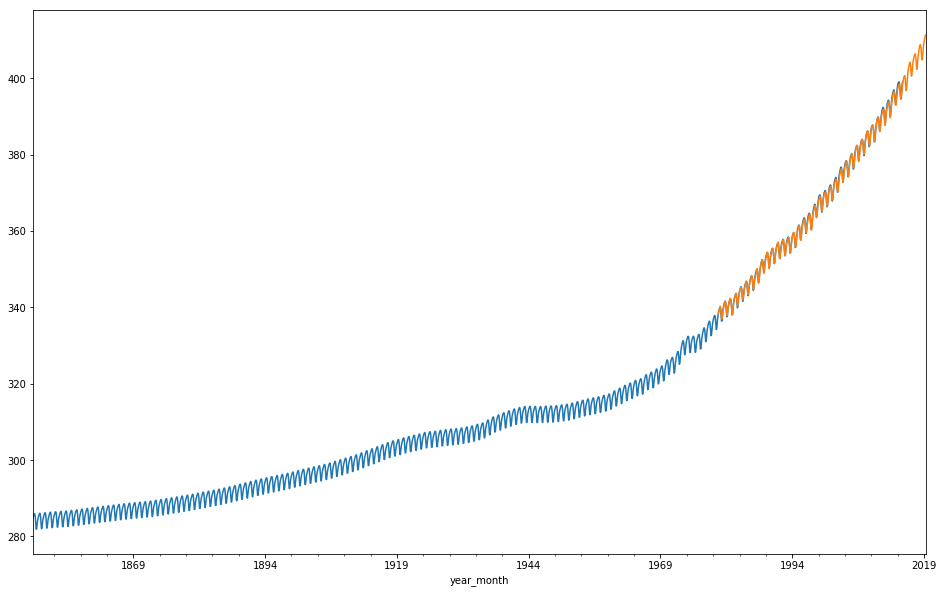

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
cmip6.loc["1850":]["data_mean_global"].plot(ax=ax)
noaa["average"].plot(ax=ax)

In [17]:
cmip6.loc["1850":].rename(columns={"data_mean_nh": "value"}).to_csv("../public/concentrations_nh.csv", index=False)
cmip6.loc["1850":].rename(columns={"data_mean_sh": "value"}).to_csv("../public/concentrations_sh.csv", index=False)

combined = pd.concat([cmip6["data_mean_global"].loc["1850":"1979-12"], noaa["average"]])
combined = pd.DataFrame({"value": combined})
combined["year"] = combined.index.year
combined["month"] = combined.index.month
combined.index.name = "date"
combined["day"] = 15
combined = combined[["year", "month", "value"]]
combined.to_csv("../public/concentrations.csv", index=False)


## Global Temperatures

Global temperature data is taken from the HadCRUT4 near surface temperature dataset.

http://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html

In [18]:
hadcrut = pd.read_csv(
    "HadCRUT.4.5.0.0.monthly_ns_avg.txt",
    delim_whitespace=True,
    usecols=[0, 1],
    header=None
)
hadcrut['year'] = hadcrut.iloc[:, 0].apply(lambda x: x.split("/")[0]).astype(int)
hadcrut['month'] = hadcrut.iloc[:, 0].apply(lambda x: x.split("/")[1]).astype(int)

hadcrut = hadcrut.rename(columns={1: "value"})
hadcrut = hadcrut.iloc[:, 1:]


hadcrut = hadcrut.set_index(['year', 'month'])

hadcrut -= hadcrut.loc[1850:1900].mean()
hadcrut.plot()
hadcrut = hadcrut.reset_index()
plt.xlabel("Time")
plt.ylabel(u"Temperature anomalies (°C) (1850-1990 mean)")
plt.legend("")

EmptyDataError: No columns to parse from file

In [ ]:
hadcrut.to_csv("../public/temperatures.csv", index=False)